# Time Series Illustration: Monthly Sales of Champagne Data: XGboost



In [1]:

### Just to remove warnings to prettify the notebook.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/MSDS-TERM4/ML2/ARIMA/'

In [5]:
df = pd.read_csv(data_dir+'international-airline-passengers.csv')

# separate out a validation dataset
from pandas import read_csv

# Load the series without 'squeeze' parameter
series = read_csv(data_dir + 'international-airline-passengers.csv', header=0, index_col=0, parse_dates=True)

# Check for NaN values in the dataset
nan_values = series.isna().sum()

# Output the result
print(nan_values)

International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    1
dtype: int64


In [6]:
# Remove rows with NaN values
series = series.dropna()

# Rename the column to 'Passengers'
series.rename(columns=lambda x: x.strip(), inplace=True)  # This removes extra spaces if present
series.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'Passengers'}, inplace=True)

# Output the cleaned dataset
print(series)

         Passengers
Month              
1949-01       112.0
1949-02       118.0
1949-03       132.0
1949-04       129.0
1949-05       121.0
...             ...
1960-08       606.0
1960-09       508.0
1960-10       461.0
1960-11       390.0
1960-12       432.0

[144 rows x 1 columns]


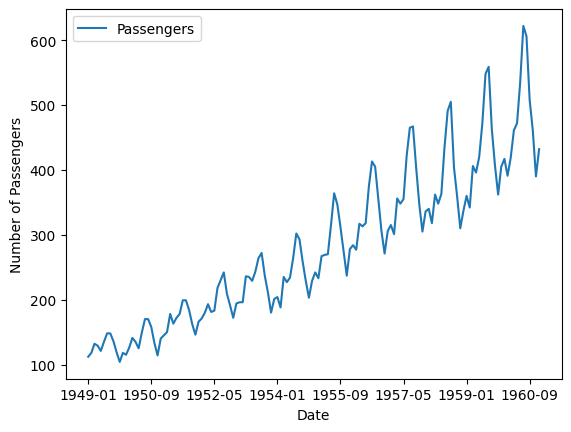

In [7]:
import pandas as pd
from matplotlib import pyplot as plt

# Plot the series with explicit label and legend enabled
series.plot()
plt.ylabel('Number of Passengers')
plt.xlabel('Date')
plt.show()

In [9]:
import numpy as np
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Load the dataset, using the second column (dates) as the index and the third column as the passenger values
series = pd.read_csv(data_dir + 'dataset.csv', header=None, usecols=[1, 2], index_col=0, parse_dates=True)

# Rename the column for clarity
series.columns = ['Passengers']

# Fix frequency issue by explicitly setting it to a monthly frequency
if not series.index.freq:
    series.index = pd.date_range(start=series.index[0], periods=len(series), freq='MS')  # Monthly Start frequency

# Define a 1-year forecast period (12 months)
forecast_horizon = 12

# Prepare the dataset for supervised learning (for XGBoost)
def create_features(df, label=None):
    df['date'] = df.index
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    X = df[['year', 'month', 'dayofyear', 'dayofweek', 'quarter']]
    if label:
        y = df[label]
        return X, y
    return X

# Use the entire dataset minus the last 12 months for training, and forecast the last 12 months
train_size = len(series) - forecast_horizon
train, forecast_period = series[:train_size], series[train_size:]

# Create features for training and forecasting
X_train, y_train = create_features(train, label='Passengers')
X_forecast = create_features(forecast_period)

# GridSearchCV to find the optimal XGBoost model
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_model = XGBRegressor()

# Use TimeSeriesSplit for time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters from the GridSearch
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the optimal XGBoost model
optimal_xgb = XGBRegressor(**best_params)
optimal_xgb.fit(X_train, y_train)

# Predict the forecast period (last 12 months)
xgboost_forecast = optimal_xgb.predict(X_forecast[:forecast_horizon])

# Print the forecast results
print(f"XGBoost forecast for the next 12 months: {xgboost_forecast}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
XGBoost forecast for the next 12 months: [333.44986 319.41644 361.19434 359.4964  365.46802 445.22238 492.27762
 494.55746 412.5783  360.79416 305.7984  339.55743]


# Compare with plot of Notebook 1 using ARIMA for the time series forecast.

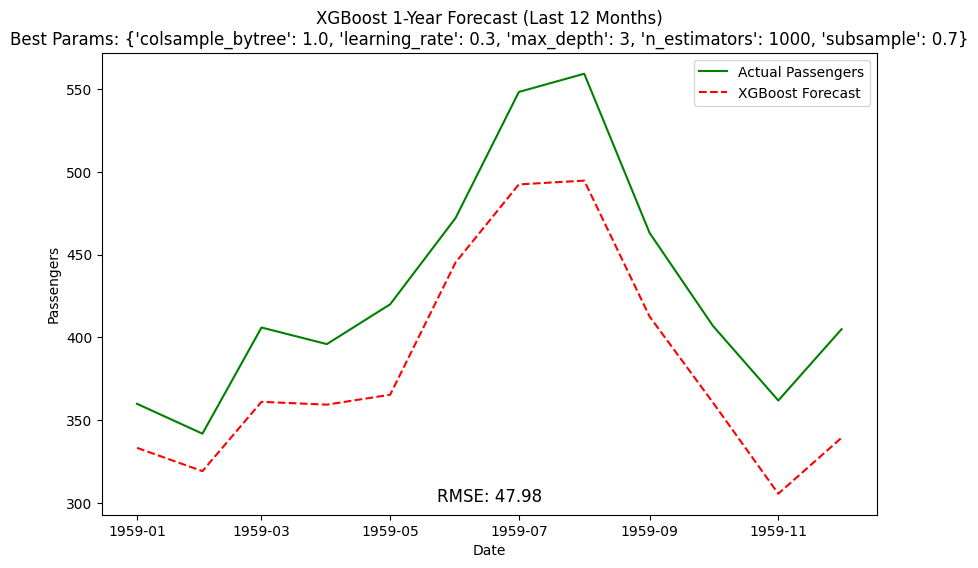

RMSE for XGBoost 1-Year Forecast: 47.97765582673965


In [11]:
# Plot the forecast results for the test set (actual sales vs. forecast)
plt.figure(figsize=(10, 6))

# Plot the actual sales data for the forecast period (last 12 months) in green.
plt.plot(forecast_period.index[:forecast_horizon], forecast_period['Passengers'][:forecast_horizon], label='Actual Passengers', color='green')

# Plot the XGBoost forecasted sales data for the same 12-month period in red with a dashed line.
plt.plot(forecast_period.index[:forecast_horizon], xgboost_forecast, label='XGBoost Forecast', linestyle='--', color='red')

# Set the x-axis label to "Date" and the y-axis label to "Sales".
plt.xlabel('Date')
plt.ylabel('Passengers')

# Add a plot title, mentioning the XGBoost forecast for the last 12 months and showing the best parameters used in the model.
plt.title(f'XGBoost 1-Year Forecast (Last 12 Months)\nBest Params: {best_params}')

# Add a legend to differentiate between actual sales and forecasted sales.
plt.legend()

# Display RMSE on the plot
rmse = np.sqrt(mean_squared_error(forecast_period['Passengers'][:forecast_horizon], xgboost_forecast))
plt.text(0.5, 0.02, f'RMSE: {rmse:.2f}', horizontalalignment='center', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=12)

plt.show()

# Print RMSE
print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")


This result outperforms the RMSE of 1561 obtained using ARIMA in Notebook 1, highlighting ARIMA’s limitations compared to more advanced models. In general, ARIMA tends to be less effective than its seasonal counterpart, SARIMA, as well as more modern machine learning algorithms, such as gradient boosting models described above. In ML3, you will explore how deep learning techniques like LSTMs and transformers often surpass even these models, which excel at capturing complex patterns in time series data.